In [2]:
import numpy as np
import pandas as pd
import os
import glob

import math

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms
from matplotlib.lines import Line2D

import seaborn as sns

from scipy.stats import ttest_ind

In [3]:
path = '/home/sunzid/Business'
os.chdir(path)

### Load other economic data

In [4]:
data_df = pd.read_excel('Data/work_data.xlsx')

econ_data = data_df.loc[:, ['countrycode', 'Year', 'rgdpe', 'pop', 'emp', 'hc', 'delta', 'csh_i', 'pop_growth']]
econ_data.loc[:, 'out_per_labor'] = econ_data.loc[:, 'rgdpe']/econ_data.loc[:, 'emp']
econ_data.rename(columns={'Year': 'year'}, inplace=True)
econ_data.dropna(inplace=True)

econ_data

,countrycode,year,rgdpe,pop,emp,hc,delta,csh_i,pop_growth,out_per_labor
1,AUS,2001,7.557776e+05,19.194672,9.011888,3.527512,0.027727,0.255888,1.070172,83864.513208
2,AUS,2002,7.772239e+05,19.401368,9.185279,3.516423,0.028071,0.276907,1.076840,84616.258972
3,AUS,2003,8.137689e+05,19.624166,9.398048,3.50537,0.028455,0.293764,1.148362,86589.140935
4,AUS,2004,8.441868e+05,19.879649,9.560890,3.494351,0.028901,0.300734,1.301880,88295.838048
5,AUS,2005,8.743951e+05,20.178540,9.911472,3.483366,0.029453,0.298287,1.503502,88220.508187
...,...,...,...,...,...,...,...,...,...,...
291,USA,2015,1.890512e+07,320.878310,150.248474,3.728116,0.043634,0.228047,0.691899,125825.717104
292,USA,2016,1.928525e+07,323.015995,152.396957,3.733411,0.044144,0.218102,0.666198,126546.174736
293,USA,2017,1.975475e+07,325.084756,154.672318,3.738714,0.044637,0.219850,0.640452,127720.036259
294,USA,2018,2.036944e+07,327.096265,156.675903,3.744024,0.045241,0.223556,0.618764,130010.037079


### Read and flatten tech data

In [5]:
raw_tech_data = pd.read_csv('Data/Tech_Data/1.csv')

raw_tech_data = raw_tech_data.drop(['Country Name', 'Series Code'], axis=1)

raw_tech_data = pd.melt(raw_tech_data, id_vars=['Country Code', 'Series Name'], var_name='Year', value_name='value')

raw_tech_data['Year'] = raw_tech_data['Year'].str.split(' ').str[0]

raw_tech_data['Year'] = pd.to_numeric(raw_tech_data['Year'], errors="coerce")
raw_tech_data['value'] = pd.to_numeric(raw_tech_data['value'], errors="coerce")
raw_tech_data.dropna(inplace=True)

raw_tech_data.rename(columns={'Country Code': 'countrycode', 'Series Name': 'series', 'Year': 'year'}, inplace=True)

raw_tech_data = raw_tech_data[~(raw_tech_data['year'].isin([2021, 2022, 2023])) & ~(raw_tech_data['series'].isin(['Electric power consumption (kWh per capita)']))]

tech_data = raw_tech_data


### Standardize and normalize vlaues

In [6]:
# Standardization (Z-score normalization)
tech_data.loc[:, 'tech_norm_val'] = tech_data.groupby('series')['value'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Normalization (min-max normalization)
tech_data.loc[:, 'tech_norm_val'] = tech_data.groupby('series')['tech_norm_val'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# % change
tech_data.loc[:, 'tech_pct_change'] = tech_data.groupby(['countrycode', 'series'])['value'].transform(
    lambda x: x.pct_change() if not x.empty else np.nan)
tech_data = tech_data.dropna()

#replace tech attribute names

replace_dict = {'Individuals using the Internet (% of population)': 'internet_user_percent',
                'Mobile cellular subscriptions (per 100 people)': 'mobile_subscriber_per_hundred',
                'Researchers in R&D (per million people)': 'researcher_per_million',
                'Research and development expenditure (% of GDP)': 'rnd_exp_gpd_percent',
                'Patent applications, residents': 'total_patents',
                'ICT service exports (% of service exports, BoP)': 'ict_export_bop_percent',
                'High-technology exports (current US$)': 'highTech_export_usd'}

tech_data.loc[:, 'series'] = tech_data.loc[:, 'series'].replace(replace_dict)


# Pivot the DataFrame
tech_pivot = tech_data.pivot_table(index=['countrycode', 'year'], columns='series', values='tech_norm_val', aggfunc='mean')

tech_pivot = tech_pivot.loc[tech_pivot.index.get_level_values('countrycode').isin(econ_data['countrycode'])]


### Select which tech attributes to keep

In [7]:
count_non_nan = tech_pivot.count().reset_index()
count_non_nan.columns = ['series', 'count_non_nan']
count_non_nan


,series,count_non_nan
0,highTech_export_usd,182
1,ict_export_bop_percent,236
2,internet_user_percent,236
3,mobile_subscriber_per_hundred,238
4,researcher_per_million,194
5,rnd_exp_gpd_percent,208
6,total_patents,233


In [8]:
tech_pivot = tech_pivot.drop(columns=['highTech_export_usd', 'researcher_per_million', 'rnd_exp_gpd_percent'])

### Merge tech data

In [9]:
econ_df = pd.merge(econ_data, tech_pivot, on=['countrycode', 'year'], how='inner')
econ_df.dropna(inplace=True)
econ_df

,countrycode,year,rgdpe,pop,emp,hc,delta,csh_i,pop_growth,out_per_labor,ict_export_bop_percent,internet_user_percent,mobile_subscriber_per_hundred,total_patents
2,AUS,2006,9.072707e+05,20.526303,10.164608,3.472417,0.030054,0.296635,1.723430,89257.813715,0.063547,0.659918,0.330878,0.002035
3,AUS,2007,9.384708e+05,20.916344,10.489001,3.461501,0.030694,0.302833,1.900201,89471.888264,0.061301,0.694426,0.349806,0.001949
4,AUS,2008,9.544999e+05,21.332282,10.757757,3.45062,0.031332,0.278304,1.988579,88726.666806,0.058418,0.716632,0.356822,0.002023
5,AUS,2009,9.708675e+05,21.750851,10.853536,3.439774,0.031846,0.268866,1.962139,89451.726250,0.059948,0.742438,0.351277,0.001789
6,AUS,2010,1.038250e+06,22.154679,11.121261,3.428961,0.032272,0.250366,1.856608,93357.199631,0.056662,0.759942,0.350230,0.001728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,USA,2015,1.890512e+07,320.878310,150.248474,3.728116,0.043634,0.228047,0.691899,125825.717104,0.086988,0.745481,0.350658,0.206867
216,USA,2016,1.928525e+07,323.015995,152.396957,3.733411,0.044144,0.218102,0.666198,126546.174736,0.088980,0.855409,0.354302,0.211883
217,USA,2017,1.975475e+07,325.084756,154.672318,3.738714,0.044637,0.219850,0.640452,127720.036259,0.092069,0.872718,0.353477,0.210862
218,USA,2018,2.036944e+07,327.096265,156.675903,3.744024,0.045241,0.223556,0.618764,130010.037079,0.092055,0.884961,0.359374,0.204542


### Combine all tech attributes to get one tech growth

In [10]:
tech_outputPerLabor_corr = econ_df[['out_per_labor', 'ict_export_bop_percent',
                    'internet_user_percent', 'mobile_subscriber_per_hundred',
                    'total_patents']].corr()
tech_cor_weights = tech_outputPerLabor_corr.loc['out_per_labor',list(tech_pivot.columns)]

In [11]:
econ_df.loc[:,'wght_tech_norm_val'] = econ_df.apply(
    lambda row: sum(row[col] * tech_cor_weights[col] for col in list(tech_pivot.columns)),
    axis=1
)
econ_df = econ_df.drop(columns=list(tech_pivot.columns))

econ_df.loc[:,'wght_norm_tech_growth'] = econ_df.loc[:,'wght_tech_norm_val'].pct_change()

econ_df.dropna(inplace=True)

econ_df

,countrycode,year,rgdpe,pop,emp,hc,delta,csh_i,pop_growth,out_per_labor,wght_tech_norm_val,wght_norm_tech_growth
3,AUS,2007,9.384708e+05,20.916344,10.489001,3.461501,0.030694,0.302833,1.900201,89471.888264,0.523792,0.048127
4,AUS,2008,9.544999e+05,21.332282,10.757757,3.45062,0.031332,0.278304,1.988579,88726.666806,0.537751,0.026651
5,AUS,2009,9.708675e+05,21.750851,10.853536,3.439774,0.031846,0.268866,1.962139,89451.726250,0.553494,0.029275
6,AUS,2010,1.038250e+06,22.154679,11.121261,3.428961,0.032272,0.250366,1.856608,93357.199631,0.562861,0.016924
7,AUS,2011,1.084070e+06,22.538001,11.326356,3.442167,0.032742,0.253104,1.730208,95712.171797,0.587743,0.044207
...,...,...,...,...,...,...,...,...,...,...,...,...
215,USA,2015,1.890512e+07,320.878310,150.248474,3.728116,0.043634,0.228047,0.691899,125825.717104,0.601797,0.022797
216,USA,2016,1.928525e+07,323.015995,152.396957,3.733411,0.044144,0.218102,0.666198,126546.174736,0.672918,0.118181
217,USA,2017,1.975475e+07,325.084756,154.672318,3.738714,0.044637,0.219850,0.640452,127720.036259,0.684720,0.017539
218,USA,2018,2.036944e+07,327.096265,156.675903,3.744024,0.045241,0.223556,0.618764,130010.037079,0.692357,0.011153


### Final correlations

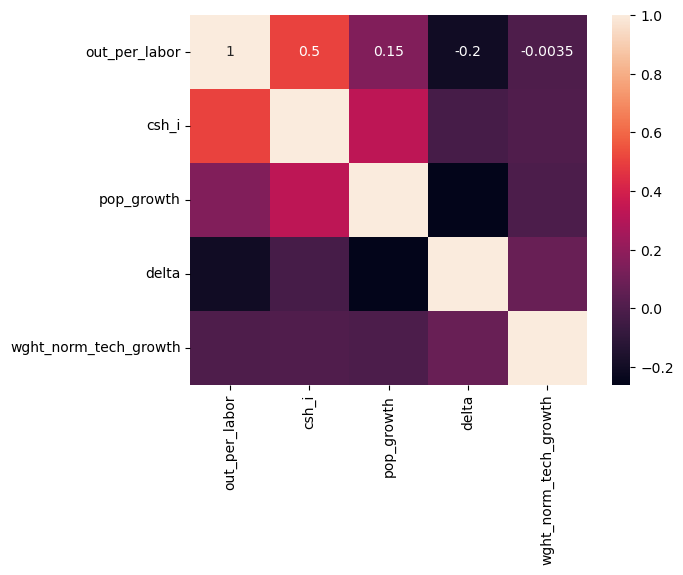

In [12]:
mrw_corr = econ_df.loc[:, ['out_per_labor', 'csh_i', 'pop_growth', 'delta', 'wght_norm_tech_growth']].corr()
sns.heatmap(mrw_corr, annot=True)
plt.show()

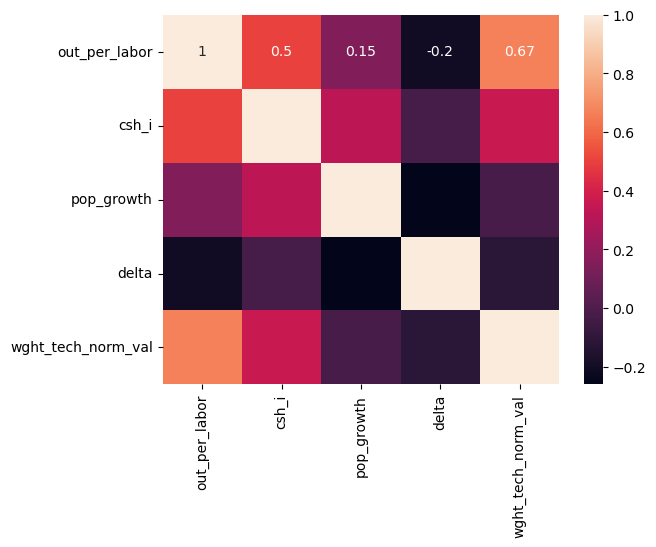

In [199]:
mrw_corr = econ_df.loc[:, ['out_per_labor', 'csh_i', 'pop_growth', 'delta', 'wght_tech_norm_val']].corr()
sns.heatmap(mrw_corr, annot=True)
plt.show()

# MRW Model

In [2]:
import numpy as np
import pandas as pd
import os
import glob

import math

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms
from matplotlib.lines import Line2D

import seaborn as sns

from scipy.stats import ttest_ind

In [3]:
path = '/home/sunzid/Business'
os.chdir(path)

## Data processing

### Load penn data

In [4]:
data_df = pd.read_excel('Data/work_data.xlsx')

econ_data = data_df.loc[:, ['countrycode', 'Year', 'rgdpe', 'pop', 'emp', 'hc', 'delta', 'csh_i']]
econ_data.loc[:, 'out_per_labor'] = econ_data.loc[:, 'rgdpe']/econ_data.loc[:, 'emp']
econ_data.rename(columns={'Year': 'year'}, inplace=True)
econ_data.dropna(inplace=True)

econ_data

,countrycode,year,rgdpe,pop,emp,hc,delta,csh_i,out_per_labor
0,AUS,2000,7.290989e+05,18.991431,8.902647,3.538635,0.027462,0.243354,81896.871345
1,AUS,2001,7.557776e+05,19.194672,9.011888,3.527512,0.027727,0.255888,83864.513208
2,AUS,2002,7.772239e+05,19.401368,9.185279,3.516423,0.028071,0.276907,84616.258972
3,AUS,2003,8.137689e+05,19.624166,9.398048,3.50537,0.028455,0.293764,86589.140935
4,AUS,2004,8.441868e+05,19.879649,9.560890,3.494351,0.028901,0.300734,88295.838048
...,...,...,...,...,...,...,...,...,...
291,USA,2015,1.890512e+07,320.878310,150.248474,3.728116,0.043634,0.228047,125825.717104
292,USA,2016,1.928525e+07,323.015995,152.396957,3.733411,0.044144,0.218102,126546.174736
293,USA,2017,1.975475e+07,325.084756,154.672318,3.738714,0.044637,0.219850,127720.036259
294,USA,2018,2.036944e+07,327.096265,156.675903,3.744024,0.045241,0.223556,130010.037079


### Load capital data

In [5]:
raw_capital_data.columns


NameError: name 'raw_capital_data' is not defined

In [6]:
raw_capital_data = pd.read_csv('Data/capital_data.csv', skiprows=3).rename(
                    columns={'Country Code': 'countrycode'})

raw_capital_data = raw_capital_data.drop(['Country Name', 'Indicator Name', 'Indicator Code', 'Unnamed: 68'], axis=1)

raw_capital_data = pd.melt(raw_capital_data, id_vars=['countrycode'], var_name='year', value_name='capital_value')

raw_capital_data['year'] = pd.to_numeric(raw_capital_data['year'], errors="coerce")
raw_capital_data['capital_value'] = pd.to_numeric(raw_capital_data['capital_value'], errors="coerce")
raw_capital_data.dropna(inplace=True)

raw_capital_data = raw_capital_data[~(raw_capital_data['year'].isin([2021, 2022, 2023]))]

capital_data = raw_capital_data

### Load tech data

In [7]:
raw_tech_data = pd.read_csv('Data/Tech_Data/1.csv')

raw_tech_data = raw_tech_data.drop(['Country Name', 'Series Code'], axis=1)

raw_tech_data = pd.melt(raw_tech_data, id_vars=['Country Code', 'Series Name'], var_name='Year', value_name='value')

raw_tech_data['Year'] = raw_tech_data['Year'].str.split(' ').str[0]

raw_tech_data['Year'] = pd.to_numeric(raw_tech_data['Year'], errors="coerce")
raw_tech_data['value'] = pd.to_numeric(raw_tech_data['value'], errors="coerce")
raw_tech_data.dropna(inplace=True)

raw_tech_data.rename(columns={'Country Code': 'countrycode', 'Series Name': 'series', 'Year': 'year'}, inplace=True)

raw_tech_data = raw_tech_data[~(raw_tech_data['year'].isin([2021, 2022, 2023])) & ~(raw_tech_data['series'].isin(['Electric power consumption (kWh per capita)']))]

tech_data = raw_tech_data


#### Standardize and normalize vlaues

In [8]:
# Standardization (Z-score normalization)
tech_data.loc[:, 'tech_norm_val'] = tech_data.groupby('series')['value'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Normalization (min-max normalization)
tech_data.loc[:, 'tech_norm_val'] = tech_data.groupby('series')['tech_norm_val'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# # % change
# tech_data.loc[:, 'tech_pct_change'] = tech_data.groupby(['countrycode', 'series'])['value'].transform(
#     lambda x: x.pct_change() if not x.empty else np.nan)
# tech_data = tech_data.dropna()

#replace tech attribute names

replace_dict = {'Individuals using the Internet (% of population)': 'internet_user_percent',
                'Mobile cellular subscriptions (per 100 people)': 'mobile_subscriber_per_hundred',
                'Researchers in R&D (per million people)': 'researcher_per_million',
                'Research and development expenditure (% of GDP)': 'rnd_exp_gpd_percent',
                'Patent applications, residents': 'total_patents',
                'ICT service exports (% of service exports, BoP)': 'ict_export_bop_percent',
                'High-technology exports (current US$)': 'highTech_export_usd'}

tech_data.loc[:, 'series'] = tech_data.loc[:, 'series'].replace(replace_dict)


# Pivot the DataFrame
tech_pivot = tech_data.pivot_table(index=['countrycode', 'year'], columns='series', values='tech_norm_val', aggfunc='mean')

tech_pivot = tech_pivot.loc[tech_pivot.index.get_level_values('countrycode').isin(econ_data['countrycode'])]


#### Select which tech attributes to keep

In [9]:
count_non_nan = tech_pivot.count().reset_index()
count_non_nan.columns = ['series', 'count_non_nan']
count_non_nan


,series,count_non_nan
0,highTech_export_usd,196
1,ict_export_bop_percent,250
2,internet_user_percent,250
3,mobile_subscriber_per_hundred,252
4,researcher_per_million,208
5,rnd_exp_gpd_percent,222
6,total_patents,247


In [10]:
tech_pivot = tech_pivot.drop(columns=['highTech_export_usd', 'researcher_per_million', 'rnd_exp_gpd_percent'])

### Merge tech data

In [11]:
econ_df = pd.merge(econ_data, tech_pivot, on=['countrycode', 'year'], how='inner')
econ_df.dropna(inplace=True)
econ_df

,countrycode,year,rgdpe,pop,emp,hc,delta,csh_i,out_per_labor,ict_export_bop_percent,internet_user_percent,mobile_subscriber_per_hundred,total_patents
2,AUS,2005,8.743951e+05,20.178540,9.911472,3.483366,0.029453,0.298287,88220.508187,0.065628,0.629911,0.312929,0.001832
3,AUS,2006,9.072707e+05,20.526303,10.164608,3.472417,0.030054,0.296635,89257.813715,0.063547,0.659918,0.330878,0.002035
4,AUS,2007,9.384708e+05,20.916344,10.489001,3.461501,0.030694,0.302833,89471.888264,0.061301,0.694426,0.349806,0.001949
5,AUS,2008,9.544999e+05,21.332282,10.757757,3.45062,0.031332,0.278304,88726.666806,0.058418,0.716632,0.356822,0.002023
6,AUS,2009,9.708675e+05,21.750851,10.853536,3.439774,0.031846,0.268866,89451.726250,0.059948,0.742438,0.351277,0.001789
...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,USA,2015,1.890512e+07,320.878310,150.248474,3.728116,0.043634,0.228047,125825.717104,0.086988,0.745481,0.350658,0.206867
230,USA,2016,1.928525e+07,323.015995,152.396957,3.733411,0.044144,0.218102,126546.174736,0.088980,0.855409,0.354302,0.211883
231,USA,2017,1.975475e+07,325.084756,154.672318,3.738714,0.044637,0.219850,127720.036259,0.092069,0.872718,0.353477,0.210862
232,USA,2018,2.036944e+07,327.096265,156.675903,3.744024,0.045241,0.223556,130010.037079,0.092055,0.884961,0.359374,0.204542


### Combine all tech attributes based on correlation with output growth to get one tech growth

In [12]:
tech_outputPerLabor_corr = econ_df[['out_per_labor', 'ict_export_bop_percent',
                    'internet_user_percent', 'mobile_subscriber_per_hundred',
                    'total_patents']].corr()
tech_cor_weights = tech_outputPerLabor_corr.loc['out_per_labor',list(tech_pivot.columns)]

econ_df.loc[:,'wght_tech_norm_val'] = econ_df.apply(
    lambda row: sum(row[col] * tech_cor_weights[col] for col in list(tech_pivot.columns)),
    axis=1
)
econ_df = econ_df.drop(columns=list(tech_pivot.columns)).reset_index()
econ_df = econ_df.drop(columns=['index', 'out_per_labor'])

econ_df.dropna(inplace=True)

econ_df

,countrycode,year,rgdpe,pop,emp,hc,delta,csh_i,wght_tech_norm_val
0,AUS,2005,8.743951e+05,20.178540,9.911472,3.483366,0.029453,0.298287,0.498753
1,AUS,2006,9.072707e+05,20.526303,10.164608,3.472417,0.030054,0.296635,0.521077
2,AUS,2007,9.384708e+05,20.916344,10.489001,3.461501,0.030694,0.302833,0.546350
3,AUS,2008,9.544999e+05,21.332282,10.757757,3.45062,0.031332,0.278304,0.560818
4,AUS,2009,9.708675e+05,21.750851,10.853536,3.439774,0.031846,0.268866,0.576381
...,...,...,...,...,...,...,...,...,...
220,USA,2015,1.890512e+07,320.878310,150.248474,3.728116,0.043634,0.228047,0.624788
221,USA,2016,1.928525e+07,323.015995,152.396957,3.733411,0.044144,0.218102,0.696664
222,USA,2017,1.975475e+07,325.084756,154.672318,3.738714,0.044637,0.219850,0.708498
223,USA,2018,2.036944e+07,327.096265,156.675903,3.744024,0.045241,0.223556,0.716514


## Calculations

### 1. Production
$$Y(t)=K(t)^\alpha(A(t)L(t))^{1-\alpha}$$

In [13]:
alpha = 0.33

/home/sunzid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sunzid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


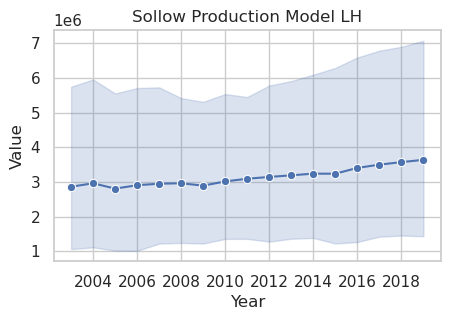

/home/sunzid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sunzid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


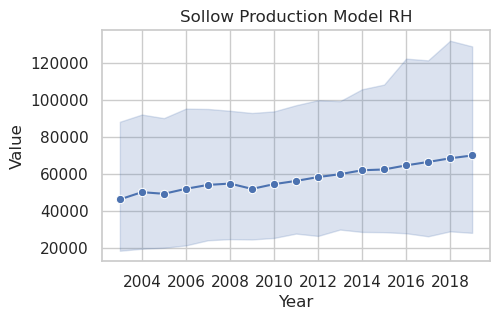

In [14]:
production_df = pd.merge(econ_df.loc[:,['countrycode', 'year', 'rgdpe', 'emp', 'wght_tech_norm_val']],
                         capital_data.loc[:,['countrycode', 'year', 'capital_value']],
                         on=['countrycode', 'year'], how='inner')

production_df.dropna(inplace=True)

production_df.loc[:,'Production_RH'] = ((production_df.loc[:,'capital_value']**alpha)*
                                        (production_df.loc[:,'wght_tech_norm_val']*
                                         production_df.loc[:,'emp'])**(1-alpha))


# production_df.loc[:,'rgdpe_actual'] = production_df.loc[:,'rgdpe']*10000

sns.set(style="whitegrid")
plt.figure(figsize=(5, 3))
sns.lineplot(data=production_df, x='year', y='rgdpe', marker='o')
plt.title('Sollow Production Model LH')
plt.xlabel('Year')
plt.ylabel('Value')
# plt.ticklabel_format(style='plain', axis='y')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()

sns.set(style="whitegrid")
plt.figure(figsize=(5, 3))
sns.lineplot(data=production_df, x='year', y='Production_RH', marker='o')
plt.title('Sollow Production Model RH')
plt.xlabel('Year')
plt.ylabel('Value')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()


### 2. Tech growth rate, n
$$n=\frac{1}{m}\ln\frac{A(m)}{A(0)}$$

/home/sunzid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sunzid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


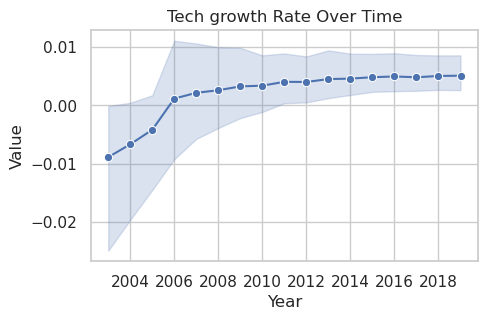

In [15]:
tech_growth_df = econ_df.loc[:, ['countrycode', 'year', 'wght_tech_norm_val']]
tech_growth_df.loc[:,['tech_growth']] = (1/(tech_growth_df.index))*(np.log(tech_growth_df.loc[:,'wght_tech_norm_val']/tech_growth_df.loc[0,'wght_tech_norm_val']))

sns.set(style="whitegrid")
plt.figure(figsize=(5, 3))
sns.lineplot(data=tech_growth_df, x='year', y='tech_growth', marker='o')
plt.title('Tech growth Rate Over Time')
plt.xlabel('Year')
plt.ylabel('Value')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()


### 3. Labor growth rate, g
$$g=\frac{1}{m}\ln\frac{L(m)}{L(0)}$$

/home/sunzid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sunzid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


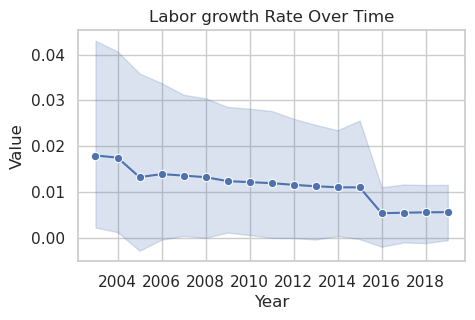

In [16]:
labor_growth_df = econ_df.loc[:, ['countrycode', 'year', 'emp']]
labor_growth_df.loc[:,['labor_growth']] = (1/(labor_growth_df.index))*(np.log(labor_growth_df.loc[:,'emp']/labor_growth_df.loc[0,'emp']))

sns.set(style="whitegrid")
plt.figure(figsize=(5, 3))
sns.lineplot(data=labor_growth_df, x='year', y='labor_growth', marker='o')
plt.title('Labor growth Rate Over Time')
plt.xlabel('Year')
plt.ylabel('Value')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()


### Output per effective unit of labor

$$y=\frac{Y}{AL}$$

/home/sunzid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sunzid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


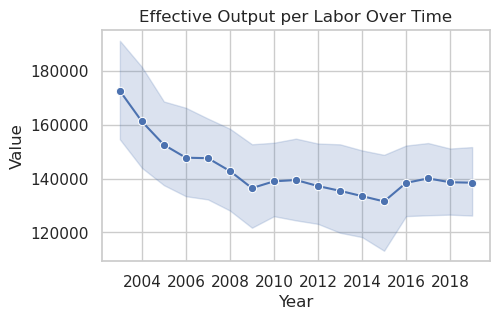

In [17]:
output_per_labor_df = econ_df.loc[:, ['countrycode', 'year', 'rgdpe', 'emp', 'wght_tech_norm_val']]
output_per_labor_df.loc[:,'out_per_labor'] = (output_per_labor_df.loc[:,'rgdpe']/
                                              (output_per_labor_df.loc[:,'wght_tech_norm_val']*
                                               output_per_labor_df.loc[:,'emp']))

sns.set(style="whitegrid")
plt.figure(figsize=(5, 3))
sns.lineplot(data=output_per_labor_df, x='year', y='out_per_labor', marker='o')
plt.title('Effective Output per Labor Over Time')
plt.xlabel('Year')
plt.ylabel('Value')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()


In [58]:
econ_df.columns

Index(['countrycode', 'year', 'rgdpe', 'pop', 'emp', 'hc', 'delta', 'csh_i',
       'wght_tech_norm_val'],
      dtype='object')

### 5. Steady state stock of capital per effective unit of labor
$$k^*=[\frac{s}{n+g+\delta}]^{\frac{1}{1-\alpha}}$$

/home/sunzid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sunzid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


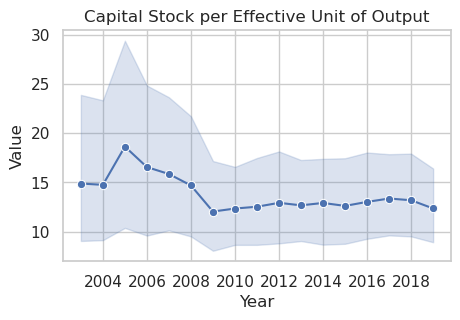

In [69]:
alpha = 0.33
capital_stock_df = pd.merge(
                pd.merge(econ_df.loc[:,['countrycode', 'year', 'csh_i', 'delta']],
                            tech_growth_df.loc[:,['countrycode', 'year','tech_growth']],
                            on=['countrycode', 'year'], how='inner'),
                            labor_growth_df.loc[:,['countrycode', 'year','labor_growth']],
                            on=['countrycode', 'year'], how='inner')

capital_stock_df.dropna(inplace=True)

capital_stock_df.loc[:,'capital_stock_PEO'] = ((capital_stock_df.loc[:,'csh_i']/
                                               (capital_stock_df.loc[:,'tech_growth']+
                                                capital_stock_df.loc[:,'labor_growth']+
                                                capital_stock_df.loc[:,'delta']))**
                                                (1/(1-alpha)))

sns.set(style="whitegrid")
plt.figure(figsize=(5, 3))
sns.lineplot(data=capital_stock_df, x='year', y='capital_stock_PEO', marker='o')
plt.title('Capital Stock per Effective Unit of Output')
plt.xlabel('Year')
plt.ylabel('Value')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()



### 6. Steady state income per capita
$$\ln{\left[\frac{Y(t)}{L(t)}\right]}=\ln{A(0)}+gt+\frac{\alpha}{1-\alpha}\ln{(s)}-\frac{\alpha}{1-\alpha}ln{(n+g+\delta)}$$

$$\ln{\left[\frac{Y}{L}\right]}=a+\frac{\alpha}{1-\alpha}\ln{(s)}-\frac{\alpha}{1-\alpha}ln{(n+g+\delta)}+\epsilon$$

/home/sunzid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sunzid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


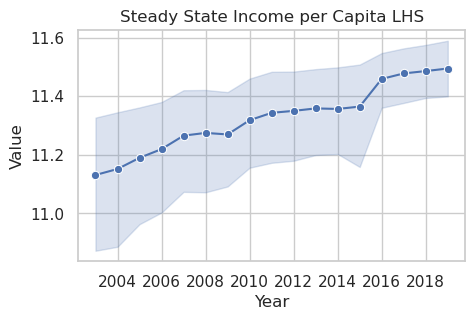

/home/sunzid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sunzid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


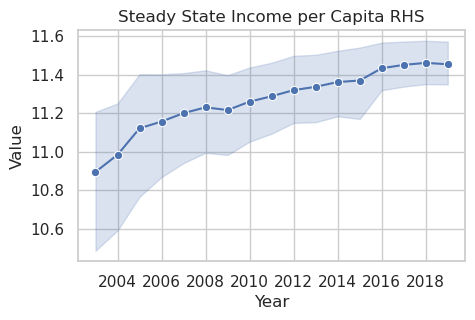

In [92]:
SS_income_perCapita_df = pd.merge(
                pd.merge(econ_df.loc[:,['countrycode', 'year', 'rgdpe', 'emp', 'csh_i', 'delta']],
                            tech_growth_df.loc[:,['countrycode', 'year', 'wght_tech_norm_val','tech_growth']],
                            on=['countrycode', 'year'], how='inner'),
                            labor_growth_df.loc[:,['countrycode', 'year','labor_growth']],
                            on=['countrycode', 'year'], how='inner')

# Left hand side
SS_income_perCapita_df.loc[:,'IPC_LH'] = np.log(SS_income_perCapita_df.loc[:,'rgdpe']/
                                                SS_income_perCapita_df.loc[:,'emp'])

# Right hand side
base_tech = 11
epsilon = (SS_income_perCapita_df.loc[0,'wght_tech_norm_val']-a)

SS_income_perCapita_df.loc[:,'IPC_RH1'] = ((alpha/(1-alpha))*np.log(SS_income_perCapita_df.loc[:,'csh_i'])-
                                          (alpha/(1-alpha))*np.log(SS_income_perCapita_df.loc[:,'tech_growth']+
                                                                  SS_income_perCapita_df.loc[:,'labor_growth']+
                                                                  SS_income_perCapita_df.loc[:,'delta'])+
                                                                  np.log(SS_income_perCapita_df.loc[0,'wght_tech_norm_val'])+
                                                                  (SS_income_perCapita_df.loc[:,'tech_growth']*
                                                                   SS_income_perCapita_df.index)+
                                                                   base_tech)

## Plot
sns.set(style="whitegrid")
plt.figure(figsize=(5, 3))
sns.lineplot(data=SS_income_perCapita_df, x='year', y='IPC_LH', marker='o')
plt.title('Steady State Income per Capita LHS')
plt.xlabel('Year')
plt.ylabel('Value')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()


## Plot
sns.set(style="whitegrid")
plt.figure(figsize=(5, 3))
sns.lineplot(data=SS_income_perCapita_df, x='year', y='IPC_RH1', marker='o')
plt.title('Steady State Income per Capita RHS')
plt.xlabel('Year')
plt.ylabel('Value')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()

